<a href="https://colab.research.google.com/github/Healer3504/Transfer-Learning-for-Cross-Disease-Chest-X-RAY-Analysis-and-Claasification/blob/main/CAPSTONE_PRJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # upload kaggle.json here
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d artyomkolas/3-kinds-of-pneumonia
!unzip 3-kinds-of-pneumonia.zip -d dataset_folder
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = '/content/dataset_folder/Curated X-Ray Dataset'
output_dir = '/content/Preprocessed_Xray_dataset'

categories = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

train_dir = os.path.join(output_dir, 'Train')
test_dir = os.path.join(output_dir, 'Test')
val_dir = os.path.join(output_dir, 'Val')

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

def split_data(category, split_ratio=(0.7, 0.2, 0.1)):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)

    train_images, temp_images = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category))
    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category))
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category))

for category in categories:
    split_data(category)

print("✅ Data preprocessing completed!")

Streaming output truncated to the last 5000 lines.
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (691).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (692).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (693).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (694).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (695).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (696).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (697).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (698).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (699).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (7).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (70).jpg  
  inflating: dataset_folder/Curated X-Ray Dataset/Normal/Normal (700).jpg  
  inflating: dataset_folder/Curated X-Ra

In [ ]:
#VGG16 model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import json

# Paths to directories
train_dir = 'Preprocessed_Xray_dataset/Train'
val_dir = 'Preprocessed_Xray_dataset/Val'
test_dir = 'Preprocessed_Xray_dataset/Test'

# Image size and batch size
img_size = (224, 224)  # VGG16 default input size
batch_size = 32

# Image data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 categories: COVID-19, Normal, Pneumonia-Bacterial, Pneumonia-Viral

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # You can increase this value for better results
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)
# Save the history to a JSON file
with open('training_history_vgg.json', 'w') as f:
    json.dump(history.history, f)

# Save the trained model to a file
model.save('vgg16_xray_model.h5')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Obtain the true labels and predictions for calculating precision, recall, and F1 score
test_generator.reset()  # Ensure the generator starts from the beginning
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predict without specifying steps
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Calculate weighted precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
support = len(y_true)

# Print the metrics in percentage format
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Support (number of samples): {support}')

Found 6443 images belonging to 4 classes.
Found 1841 images belonging to 4 classes.
Found 924 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 190s 868ms/step - accuracy: 0.6238 - loss: 0.9562 - val_accuracy: 0.7522 - val_loss: 0.5915
Epoch 2/10
  1/201 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.6875 - loss: 0.6255

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.6875 - loss: 0.6255 - val_accuracy: 0.7939 - val_loss: 0.5607
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 158s 787ms/step - accuracy: 0.7702 - loss: 0.5921 - val_accuracy: 0.7495 - val_loss: 0.6146
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7500 - loss: 0.4952 - val_accuracy: 0.7763 - val_loss: 0.5604
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 153s 761ms/step - accuracy: 0.7814 - loss: 0.5346 - val_accuracy: 0.7675 - val_loss: 0.5613
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7500 - loss: 0.4954 - val_accuracy: 0.7763 - val_loss: 0.5417
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 156s 776ms/step - accuracy: 0.7893 - loss: 0.5241 - val_accuracy: 0.8037 - val_loss: 0.4730
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.8125 - loss: 0.5643 - val_accuracy: 0.8087 - val_loss: 0.4691
Epoch 9/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8037 - loss: 0.4914 - va

28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.8627 - loss: 0.4016
Test accuracy: 81.47%
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 739ms/step
Precision: 80.25%
Recall: 80.41%
F1 Score: 79.90%
Support (number of samples): 924


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


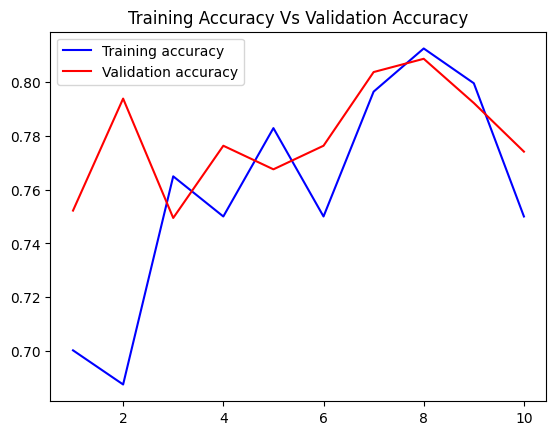

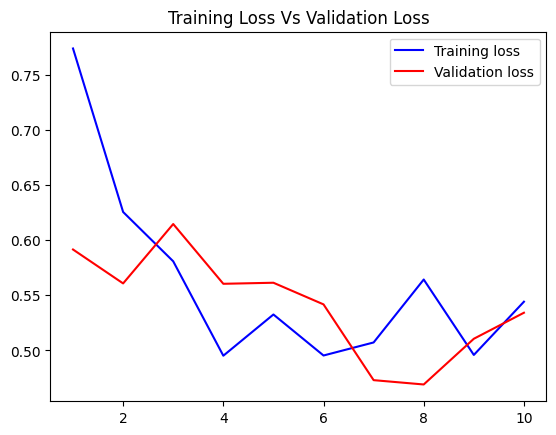

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', label='Validation accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training Loss Vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
#Xception model
#Xception
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import json

# Paths to directories
train_dir = 'Preprocessed_Xray_dataset/Train'
val_dir = 'Preprocessed_Xray_dataset/Val'
test_dir = 'Preprocessed_Xray_dataset/Test'

# Image size and batch size
img_size = (299, 299)  # Xception default input size
batch_size = 32

# Image data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load the Xception model with pre-trained ImageNet weights, excluding the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 categories: COVID-19, Normal, Pneumonia-Bacterial, Pneumonia-Viral

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10 # You can increase this value for better results
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)
# Save the history to a JSON file
with open('training_history_Xception.json', 'w') as f:
    json.dump(history.history, f)

# Save the trained model to a file
model.save('xception_xray_model.h5')

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Obtain the true labels and predictions for calculating precision, recall, and F1 score
test_generator.reset()  # Ensure the generator starts from the beginning
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator)  # Predict without specifying steps
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# Calculate weighted precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
support = len(y_true)

# Print the metrics in percentage format
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'Support (number of samples): {support}')

Found 6443 images belonging to 4 classes.
Found 1841 images belonging to 4 classes.
Found 924 images belonging to 4 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7193 - loss: 0.7075 - val_accuracy: 0.8037 - val_loss: 0.4630
Epoch 2/10
  1/201 ━━━━━━━━━━━━━━━━━━━━ 46s 231ms/step - accuracy: 0.7500 - loss: 0.4955

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 128ms/step - accuracy: 0.7500 - loss: 0.4955 - val_accuracy: 0.8043 - val_loss: 0.4708
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8132 - loss: 0.4607 - val_accuracy: 0.8081 - val_loss: 0.4494
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.8125 - loss: 0.4482 - val_accuracy: 0.8092 - val_loss: 0.4485
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8278 - loss: 0.4171 - val_accuracy: 0.8240 - val_loss: 0.4179
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.8438 - loss: 0.4885 - val_accuracy: 0.8235 - val_loss: 0.4195
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8343 - loss: 0.4074 - val_accuracy: 0.7917 - val_loss: 0.5180
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.6875 - loss: 0.6079 - val_accuracy: 0.7988 - val_loss: 0.4968
Epoch 9/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.8385 - loss: 0.4052 - val_accurac

28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9190 - loss: 0.2492
Test accuracy: 82.59%
29/29 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step
Precision: 80.67%
Recall: 81.39%
F1 Score: 80.26%
Support (number of samples): 924


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


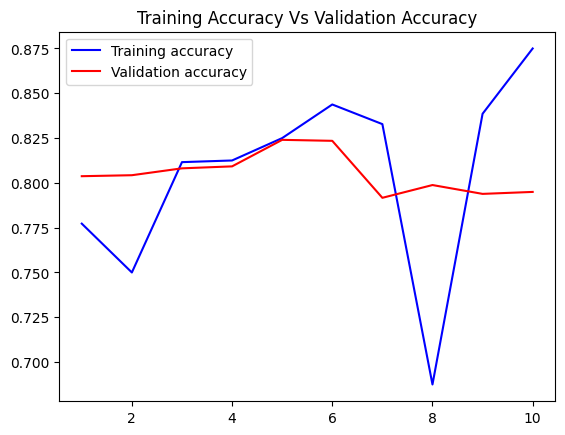

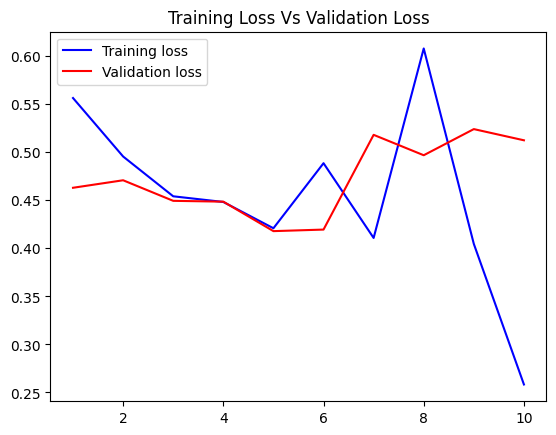

In [ ]:
#Plotting graphs- Xception
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', label='Validation accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training Loss Vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# ============================
# ENSEMBLE: Xception + VGG16
# ============================

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Paths to your saved models (both are in /content/)
xception_model_path = '/content/xception_xray_model.h5'
vgg16_model_path = '/content/vgg16_xray_model.h5'

# Dataset path
test_dir = '/content/Preprocessed_Xray_dataset/Test'

# Image sizes
xception_img_size = (299, 299)  # Xception input size
vgg16_img_size = (224, 224)     # VGG16 input size
batch_size = 32

# Image data preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Test generator for Xception
xception_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=xception_img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Test generator for VGG16
vgg16_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=vgg16_img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load trained models
xception_model = load_model(xception_model_path)
vgg16_model = load_model(vgg16_model_path)

# Ensure both generators have same number of samples
assert xception_test_generator.samples == vgg16_test_generator.samples, \
    f"❌ Mismatch in samples: Xception={xception_test_generator.samples}, VGG16={vgg16_test_generator.samples}"

# Predict using both models (same steps)
steps = xception_test_generator.samples // batch_size

print("\n🔹 Running predictions with Xception...")
xception_preds = xception_model.predict(xception_test_generator, steps=steps, verbose=1)

print("\n🔹 Running predictions with VGG16...")
vgg16_preds = vgg16_model.predict(vgg16_test_generator, steps=steps, verbose=1)

# Average the predictions (softmax outputs)
ensemble_preds = (xception_preds + vgg16_preds) / 2

# Final predicted classes
final_preds = np.argmax(ensemble_preds, axis=1)

# True labels
true_labels = xception_test_generator.classes[:len(final_preds)]

# ======================
# EVALUATION METRICS
# ======================
accuracy = np.mean(final_preds == true_labels)
precision = precision_score(true_labels, final_preds, average='weighted')
recall = recall_score(true_labels, final_preds, average='weighted')
f1 = f1_score(true_labels, final_preds, average='weighted')
support = len(true_labels)

print("\n✅ ENSEMBLE MODEL PERFORMANCE:")
print(f"Accuracy :  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1 Score : {f1 * 100:.2f}%")
print(f"Samples  : {support}")

# Optional: save ensemble predictions locally
np.save('/content/ensemble_predictions.npy', ensemble_preds)
np.save('/content/final_predicted_labels.npy', final_preds)

print("\n💾 Ensemble predictions saved in /content/")

Found 924 images belonging to 4 classes.
Found 924 images belonging to 4 classes.



🔹 Running predictions with Xception...
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step

🔹 Running predictions with VGG16...
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step

✅ ENSEMBLE MODEL PERFORMANCE:
Accuracy :  83.82%
Precision: 83.25%
Recall   : 83.82%
F1 Score : 83.13%
Samples  : 896

💾 Ensemble predictions saved in /content/


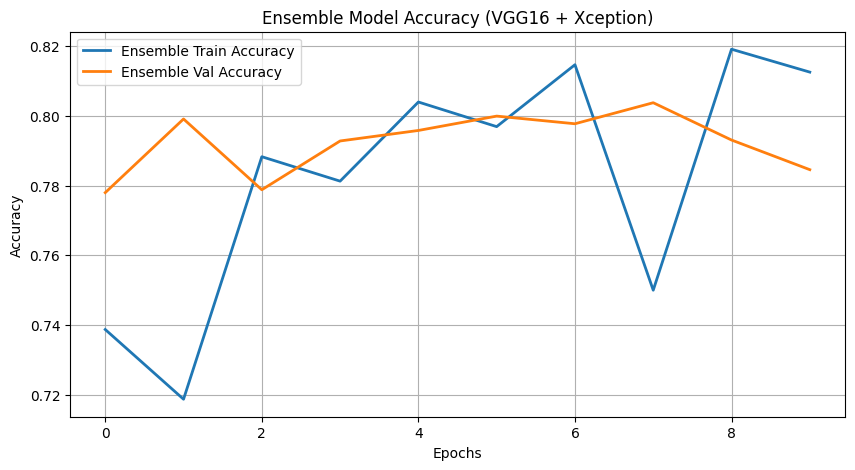

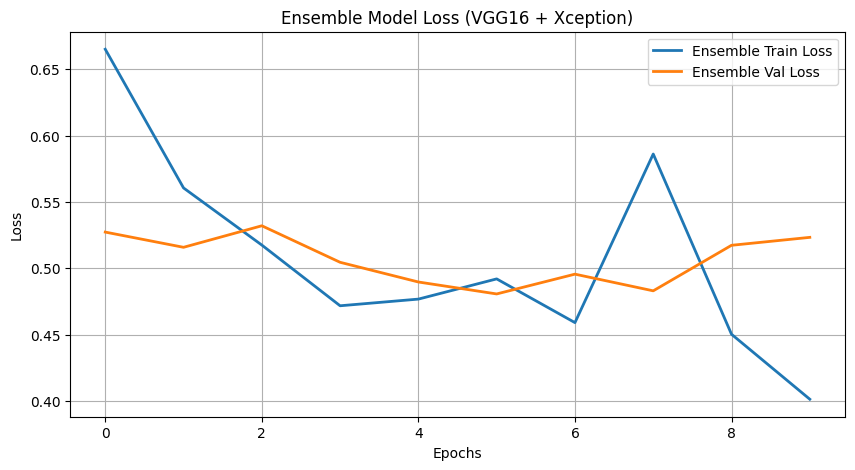

In [ ]:
import json
import matplotlib.pyplot as plt

# Load Xception training history
with open('training_history_Xception.json', 'r') as f:
    xception_history = json.load(f)

# Load VGG16 training history
with open('training_history_vgg.json', 'r') as f: # Corrected filename here
    vgg_history = json.load(f)

# Calculate ensemble (average) accuracy
combined_train_accuracy = [(x + y) / 2 for x, y in zip(xception_history['accuracy'], vgg_history['accuracy'])]
combined_val_accuracy = [(x + y) / 2 for x, y in zip(xception_history['val_accuracy'], vgg_history['val_accuracy'])]

# Calculate ensemble (average) loss
combined_train_loss = [(x + y) / 2 for x, y in zip(xception_history['loss'], vgg_history['loss'])]
combined_val_loss = [(x + y) / 2 for x, y in zip(xception_history['val_loss'], vgg_history['val_loss'])]

# Plot Ensemble Accuracy
plt.figure(figsize=(10, 5))
plt.plot(combined_train_accuracy, label='Ensemble Train Accuracy', linewidth=2)
plt.plot(combined_val_accuracy, label='Ensemble Val Accuracy', linewidth=2)
plt.title('Ensemble Model Accuracy (VGG16 + Xception)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Ensemble Loss
plt.figure(figsize=(10, 5))
plt.plot(combined_train_loss, label='Ensemble Train Loss', linewidth=2)
plt.plot(combined_val_loss, label='Ensemble Val Loss', linewidth=2)
plt.title('Ensemble Model Loss (VGG16 + Xception)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ==========================================
# DenseNet121 - ImageNet Pretrained Version
# ==========================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import json

# Paths to directories
train_dir = 'Preprocessed_Xray_dataset/Train'
val_dir = 'Preprocessed_Xray_dataset/Val'
test_dir = 'Preprocessed_Xray_dataset/Test'

# Image size and batch size
img_size = (224, 224)  # DenseNet default input size
batch_size = 32

# Image data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Load the DenseNet121 model with ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 categories: COVID-19, Normal, Pneumonia-Bacterial, Pneumonia-Viral

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # Increase for better accuracy
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

# Save training history
with open('training_history_densenet.json', 'w') as f:
    json.dump(history.history, f)

# Save the trained model in /content
model.save('/content/densenet_xray_model.h5')
print("✅ Model saved as /content/densenet_xray_model.h5")

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Predictions and metrics
test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
support = len(y_true)

print("\n📊 Model Evaluation Metrics:")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Samples Tested: {support}")

Found 6443 images belonging to 4 classes.
Found 1841 images belonging to 4 classes.
Found 924 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 228s 994ms/step - accuracy: 0.6655 - loss: 0.9165 - val_accuracy: 0.7862 - val_loss: 0.5209
Epoch 2/10
  1/201 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.7188 - loss: 0.6275

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.7188 - loss: 0.6275 - val_accuracy: 0.7807 - val_loss: 0.5366
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 160s 797ms/step - accuracy: 0.7913 - loss: 0.5070 - val_accuracy: 0.7769 - val_loss: 0.5891
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.7500 - loss: 0.5959 - val_accuracy: 0.7796 - val_loss: 0.5796
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 148s 735ms/step - accuracy: 0.8174 - loss: 0.4500 - val_accuracy: 0.7615 - val_loss: 0.5745
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.8125 - loss: 0.4185 - val_accuracy: 0.7703 - val_loss: 0.5558
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 148s 737ms/step - accuracy: 0.8154 - loss: 0.4445 - val_accuracy: 0.8306 - val_loss: 0.4152
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.7500 - loss: 0.5388 - val_accuracy: 0.8257 - val_loss: 0.4104
Epoch 9/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 183s 744ms/step - accuracy: 0.8085 - loss: 0.4550 - va

✅ Model saved as /content/densenet_xray_model.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.9509 - loss: 0.1512

Test Accuracy: 84.60%
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 861ms/step

📊 Model Evaluation Metrics:
Precision: 82.84%
Recall: 83.12%
F1 Score: 80.92%
Samples Tested: 924


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


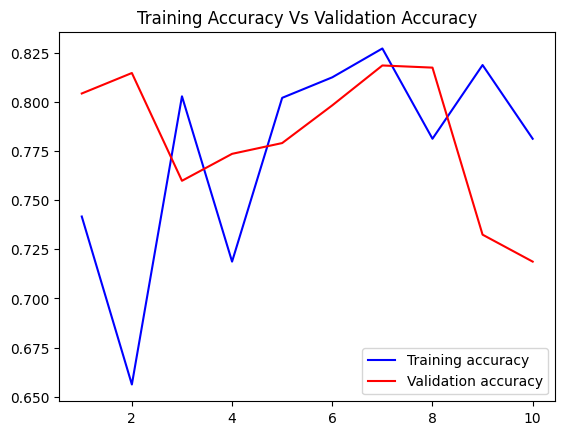

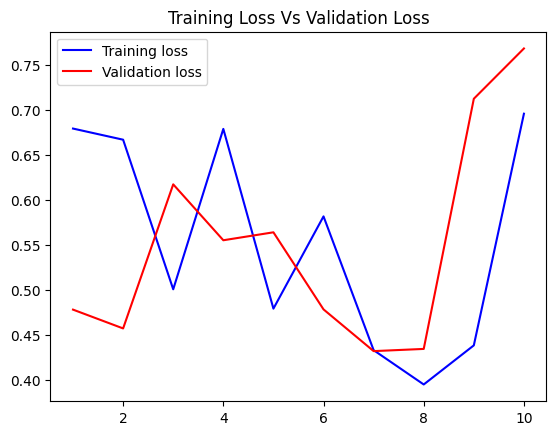

In [ ]:
#Plotting graphs- Densenet
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', label='Validation accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training Loss Vs Validation Loss')
plt.legend()
plt.show()

Found 924 images belonging to 4 classes.
Found 924 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step
📊 Ensemble Model Performance:
Accuracy : 80.25%
Precision: 80.17%
Recall   : 80.25%
F1 Score : 78.41%

Classification Report:
                     precision    recall  f1-score   support

           COVID-19       0.97      0.91      0.94       129
             Normal       0.75      1.00      0.86       328
Pneumonia-Bacterial       0.83      0.77      0.80       301
    Pneumonia-Viral       0.69      0.31      0.43       138

           accuracy                           0.80       896
          macro avg       0.81      0.75      0.76       896
       weighted avg       0.80      0.80      0.78       896



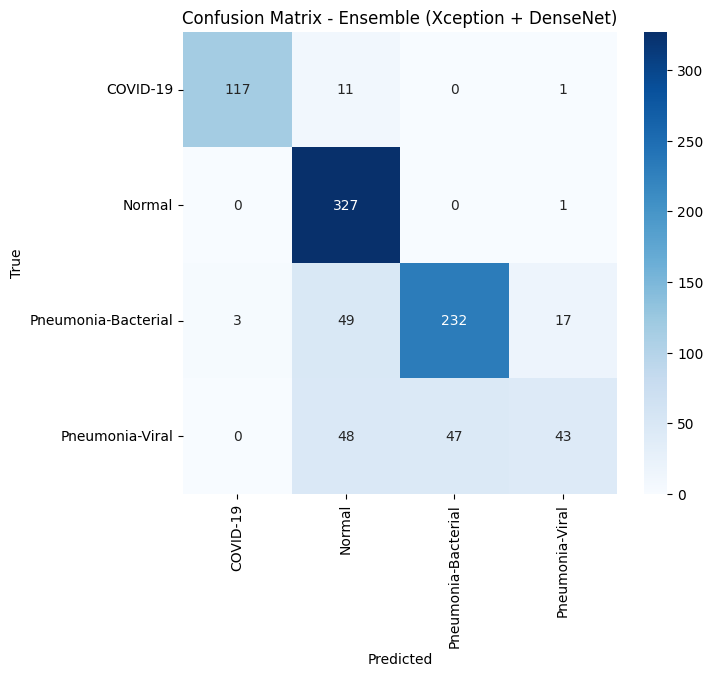

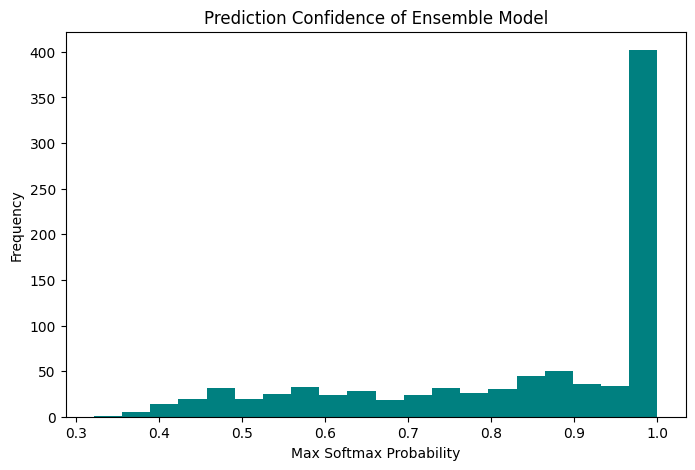

/tmp/ipython-input-3128282458.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='mako')


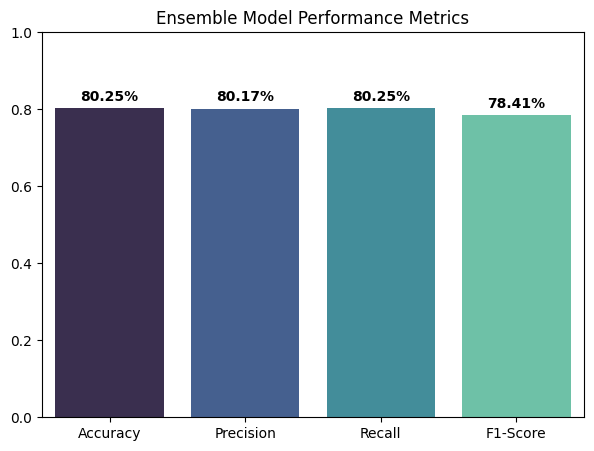

In [ ]:
# ==========================================
# 📦 ENSEMBLE OF XCEPTION + DENSENET MODELS
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# --------------------------------------------------------
# 🔹 Paths and Parameters
# --------------------------------------------------------
test_dir = 'Preprocessed_Xray_dataset/Test'
xception_img_size = (299, 299)
densenet_img_size = (224, 224)
batch_size = 32

# --------------------------------------------------------
# 🔹 Load Test Data
# --------------------------------------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

# For Xception
xception_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=xception_img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# For DenseNet
densenet_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=densenet_img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --------------------------------------------------------
# 🔹 Load Saved Models from /content/
# --------------------------------------------------------
xception_model = load_model('/content/xception_xray_model.h5')
densenet_model = load_model('/content/densenet_xray_model.h5')

# --------------------------------------------------------
# 🔹 Predictions
# --------------------------------------------------------
steps = xception_test_generator.samples // batch_size

xception_preds = xception_model.predict(xception_test_generator, steps=steps)
densenet_preds = densenet_model.predict(densenet_test_generator, steps=steps)

# Average (Soft Voting)
ensemble_preds = (xception_preds + densenet_preds) / 2

# Final Predicted Classes
final_predictions = np.argmax(ensemble_preds, axis=1)
true_labels = xception_test_generator.classes[:len(final_predictions)]
class_names = list(xception_test_generator.class_indices.keys())

# --------------------------------------------------------
# 🔹 Evaluation Metrics
# --------------------------------------------------------
accuracy = accuracy_score(true_labels, final_predictions)
precision = precision_score(true_labels, final_predictions, average='weighted')
recall = recall_score(true_labels, final_predictions, average='weighted')
f1 = f1_score(true_labels, final_predictions, average='weighted')

print("📊 Ensemble Model Performance:")
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall   : {recall * 100:.2f}%")
print(f"F1 Score : {f1 * 100:.2f}%")

# Detailed Report
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=class_names))

# --------------------------------------------------------
# 🔹 Confusion Matrix Plot
# --------------------------------------------------------
cm = confusion_matrix(true_labels, final_predictions)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Ensemble (Xception + DenseNet)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --------------------------------------------------------
# 🔹 Probability Confidence Plot
# --------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(np.max(ensemble_preds, axis=1), bins=20, color='teal')
plt.title('Prediction Confidence of Ensemble Model')
plt.xlabel('Max Softmax Probability')
plt.ylabel('Frequency')
plt.show()

# --------------------------------------------------------
# 🔹 Bar Plot of Metrics
# --------------------------------------------------------
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(7,5))
sns.barplot(x=metrics, y=values, palette='mako')
plt.title('Ensemble Model Performance Metrics')
plt.ylim(0,1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')
plt.show()

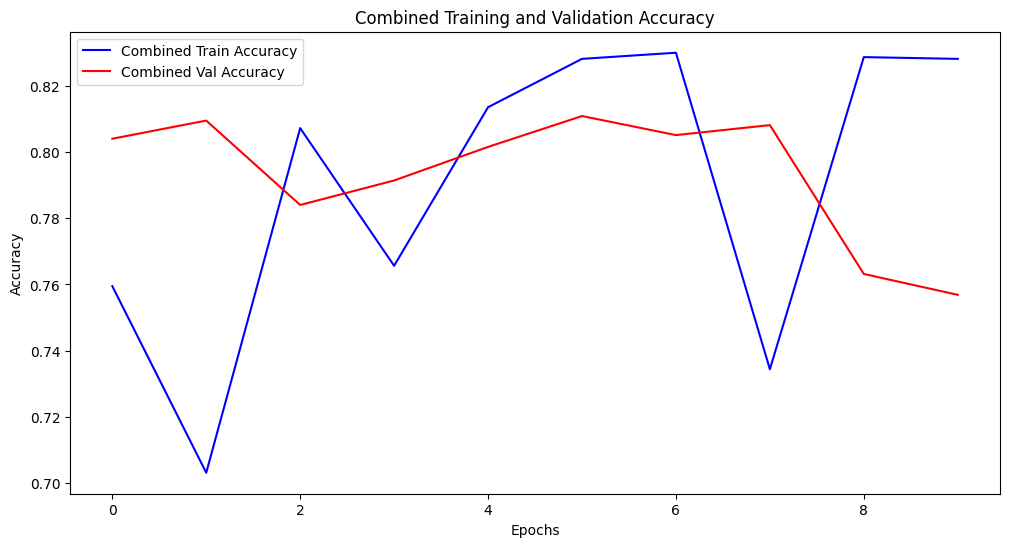

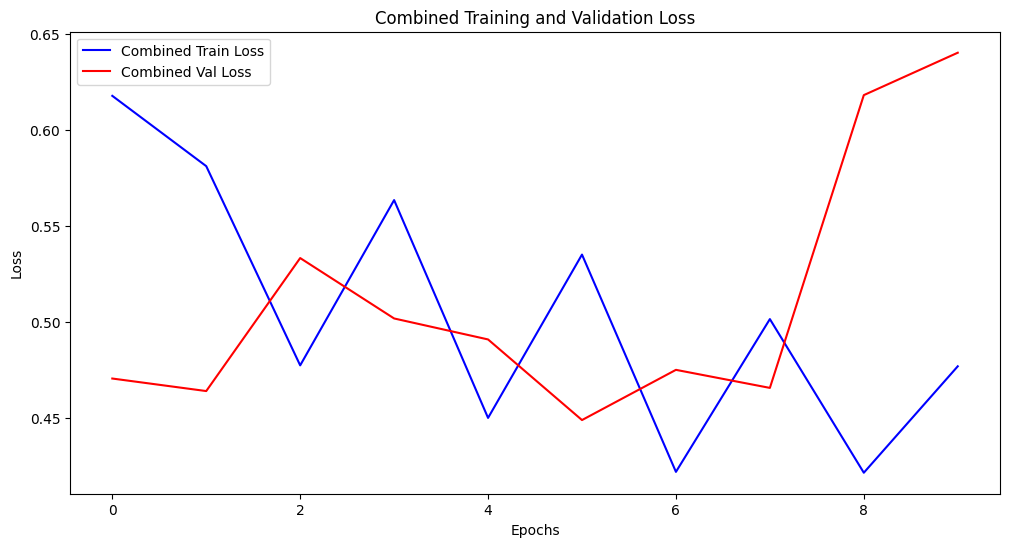

In [ ]:
#plotting graph for ensemble model-Ensemble
import json
import matplotlib.pyplot as plt

# Load history for Xception model
with open('training_history_Xception.json', 'r') as f:
    xception_history = json.load(f)

# Load history for DenseNet model
with open('training_history_densenet.json', 'r') as f:
    densenet_history = json.load(f)

# Calculate combined training and validation accuracy
combined_train_accuracy = [(x + y) / 2 for x, y in zip(xception_history['accuracy'], densenet_history['accuracy'])]
combined_val_accuracy = [(x + y) / 2 for x, y in zip(xception_history['val_accuracy'], densenet_history['val_accuracy'])]

# Plot Combined Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(combined_train_accuracy, label='Combined Train Accuracy', color='blue')
plt.plot(combined_val_accuracy, label='Combined Val Accuracy', color='red')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Optionally, plot Combined Training and Validation Loss
combined_train_loss = [(x + y) / 2 for x, y in zip(xception_history['loss'], densenet_history['loss'])]
combined_val_loss = [(x + y) / 2 for x, y in zip(xception_history['val_loss'], densenet_history['val_loss'])]

plt.figure(figsize=(12, 6))
plt.plot(combined_train_loss, label='Combined Train Loss', color='blue')
plt.plot(combined_val_loss, label='Combined Val Loss', color='red')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/Xray_Models

!cp /content/xception_xray_model.h5 /content/drive/MyDrive/Xray_Models/
!cp /content/densenet_xray_model.h5 /content/drive/MyDrive/Xray_Models/
!cp /content/vgg16_xray_model.h5 /content/drive/MyDrive/Xray_Models/
!cp /content/ensemble_predictions.npy /content/drive/MyDrive/Xray_Models/
!cp /content/final_predicted_labels.npy /content/drive/MyDrive/Xray_Models/


cp: cannot stat '/content/xception_xray_model.h5': No such file or directory
cp: cannot stat '/content/densenet_xray_model.h5': No such file or directory
cp: cannot stat '/content/vgg16_xray_model.h5': No such file or directory
cp: cannot stat '/content/ensemble_predictions.npy': No such file or directory
cp: cannot stat '/content/final_predicted_labels.npy': No such file or directory


In [ ]:
!mkdir -p /content/Xray_Models
!cp /content/drive/MyDrive/Xray_Models/* /content/Xray_Models/
!ls /content/Xray_Models


densenet_xray_model.h5	  final_predicted_labels.npy  xception_xray_model.h5
ensemble_predictions.npy  vgg16_xray_model.h5


Found 924 images belonging to 4 classes.


Class labels: ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']


Saving img3.jpeg to img3 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step

✅ Result for: img3 (1).jpeg
Predicted Class: Normal


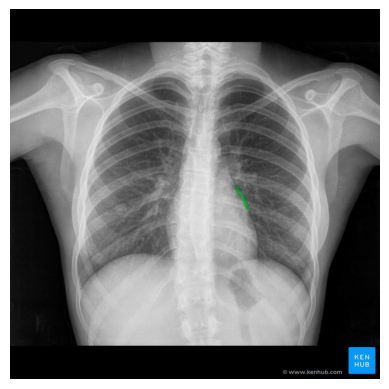

In [ ]:
# ============================
# SINGLE IMAGE PREDICTION (UPLOAD IMAGE)
# ============================

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import tensorflow as tf # Import tensorflow

# Paths to your saved models (both are in /content/)
xception_model_path = '/content/Xray_Models/xception_xray_model.h5'
vgg16_model_path = '/content/Xray_Models/vgg16_xray_model.h5'

# Dataset path
test_dir = '/content/Preprocessed_Xray_dataset/Test'

# Image sizes
xception_img_size = (299, 299)  # Xception input size
vgg16_img_size = (224, 224)     # VGG16 input size

# Image data preprocessing
test_datagen = image.ImageDataGenerator(rescale=1./255)

# Test generator for Xception (used only to get class_indices)
xception_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=xception_img_size,
    batch_size=1, # Can be 1 since we only need class_indices
    class_mode='categorical',
    shuffle=False
)

# Load trained models
xception_model = tf.keras.models.load_model(xception_model_path)
vgg16_model = tf.keras.models.load_model(vgg16_model_path)

# Class names (must match your dataset folder order)
class_names = list(xception_test_generator.class_indices.keys())
print("Class labels:", class_names)

# Upload X-ray image
uploaded = files.upload()

for filename in uploaded.keys():

    # ----- For Xception -----
    img_x = image.load_img(filename, target_size=xception_img_size)
    img_x = image.img_to_array(img_x) / 255.0
    img_x = np.expand_dims(img_x, axis=0)
    pred_x = xception_model.predict(img_x)

    # ----- For VGG16 -----
    img_v = image.load_img(filename, target_size=vgg16_img_size)
    img_v = image.img_to_array(img_v) / 255.0
    img_v = np.expand_dims(img_v, axis=0)
    pred_v = vgg16_model.predict(img_v)

    # ----- ENSEMBLE (Average) -----
    final_pred = (pred_x + pred_v) / 2
    class_index = np.argmax(final_pred)
    predicted_class = class_names[class_index]

    # Show result
    print("\n✅ Result for:", filename)
    print("Predicted Class:", predicted_class)

    # Display Image
    plt.imshow(image.load_img(filename))
    plt.axis('off')
    plt.show()
